# Multidigit MNIST(M2NIST)
<i>Description and dataset obtained from https://www.kaggle.com/farhanhubble/multimnistm2nist</i>

<img src='cover.png' width="50%"/>

### Context

I created this dataset to teach the basics of fully convolution networks for semantic segmentation of images. Most real-world semantic image segmentation tasks require building huge networks that are slow to train and experiment with. The dataset was generated by selecting up to 3 random 28px x 28px grayscale images from the MNIST dataset and copying them in to a single 64px(height) x 84px(width) image. The digits were pasted so that they did not overlap and no transformations were applied to the original images, so digits in M2NIST maintain the same orientation as the have in MNIST.

### Content

The dataset has 5000 multi-digit images in combined.npy and 11 segmentation masks for every image in segmented.npy. The files can be read in using numpy.load(), for example, as combined=np.load('combined.npy') and segmented = np.load('segmented.npy'). The data in combined.npy has shape (5000, 64, 84) while the data in segmented.npy has shape (5000, 64, 84, 11). Every element in combined.npy is a grayscale image with up to 3 digits. The corresponding element in segmented.npy is a tensor with 64 rows, 84 columns and 11 layers or channels. Each layer or channel is a binary mask. The k-th layer (0<=k<9) has 1s wherever the digit k is present in the combined image and 0s everywhere else. The last layer k=10 represents background and has 1s wherever there is no digit in the combined image and 0's wherever at pixels where some digit is present in the original image.

### Acknowledgements

This dataset is ultimately derived from the data published by YanLeCun and his group http://yann.lecun.com/exdb/mnist/index.html and is licensed under the Creative Commons Attribution-Share Alike 4.0 license. The code used to generate this dataset is available on github as an Ipython Notebook.

### Inspiration

The M2NIST dataset is released in the hope that it enables users to understand semantic segmentation and perhaps give us more insights about what neural networks learn and in turn leads us to smaller and more robust networks.

In [1]:
# Set tensorflow to use memory as needed

import tensorflow as tf 

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [2]:
# Obtain reproducible results

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

## Dataset Processing

In [3]:
import numpy as np

In [4]:
# Load dataset
# Dataset obtained from https://www.kaggle.com/farhanhubble/multimnistm2nist

data = np.load('./dataset/combined.npy').astype('float16')
labels = np.load('./dataset/segmented.npy').astype('uint8')

# Rescale input from [0,255] to [0,1]
# "...neural networks prefer to deal with small input values."
# Pg. 135, Deep Learning with Python by Chollet
data /= 255.0

# Reshape input to (samples, height, width, channels)
# Format based on Tensorflow convention
data = np.expand_dims(data, -1)

# Split data to train, val, test
x_train = data[:3000]
y_train = labels[:3000]

x_val = data[3000:4000]
y_val = labels[3000:4000]

x_test = data[4000:]
y_test = labels[4000:]

# Calculate class weights
# This is necessary since the classes are extremely imbalanced 
# due to the number of "background" pixels
freq = y_test.reshape(-1, 11).sum(axis=0, dtype='float32')
freq_rel = freq / freq.sum()
weights = 1 / freq_rel

## Model Creation and Training

The model is based on the U-Net architecture with multiple blocks omitted to minimize overfitting. The Convolutional Layers (Conv2D) are replaced with Depthwise Convolutional Layers (SeparableConv2D) to reduce the number of parameters and floating-point operations while improving accuracy (Pg. 261, Deep Learning with Python). In addition, Batch Normalization Layers are added at multiple points to ensure data normalization after transformations, which can help with generalization (Pg. 260, Deep Learning with Python).

In [5]:
from keras.models import Model
from keras.layers import Input, SeparableConv2D, Conv2DTranspose, concatenate, BatchNormalization, MaxPooling2D, Dropout

Using TensorFlow backend.


In [6]:
def build_model(input_layer):
    # Reduction
    conv1 = SeparableConv2D(8, (3,3), activation='relu', padding='same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = SeparableConv2D(8, (3,3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # Middle
    convm = SeparableConv2D(16, (3,3), activation='relu', padding='same')(pool1)
    convm = BatchNormalization()(convm)
    convm = SeparableConv2D(16, (3,3), activation='relu', padding='same')(convm)
    convm = BatchNormalization()(convm)
    
    # Expansion    
    deconv1 = Conv2DTranspose(8, (3,3), strides=(2,2), padding='same')(convm)
    deconv1 = BatchNormalization()(deconv1)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = SeparableConv2D(8, (3,3), activation='relu', padding='same')(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = SeparableConv2D(8, (3,3), activation='relu', padding='same')(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    
    output_layer = SeparableConv2D(11, (1,1), padding='same', activation='softmax')(uconv1)
    
    return output_layer

In [7]:
x = Input(shape=(64, 84, 1))
y = build_model(x)
model = Model(inputs=x, outputs=y)

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 84, 1)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 64, 84, 8)    25          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 84, 8)    32          separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
separable_conv2d_2 (SeparableCo (None, 64, 84, 8)    144         batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [10]:
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val), class_weight=weights, verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
3000/3000 [==============================] - 27s 9ms/step - loss: 2.1851 - acc: 0.6666 - val_loss: 1.8294 - val_acc: 0.9425
Epoch 2/10
3000/3000 [==============================] - 21s 7ms/step - loss: 1.4897 - acc: 0.8961 - val_loss: 0.6793 - val_acc: 0.9425
Epoch 3/10
3000/3000 [==============================] - 20s 7ms/step - loss: 0.6888 - acc: 0.9383 - val_loss: 0.3107 - val_acc: 0.9433
Epoch 4/10
3000/3000 [==============================] - 20s 7ms/step - loss: 0.3075 - acc: 0.9462 - val_loss: 0.2288 - val_acc: 0.9458
Epoch 5/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.2110 - acc: 0.9474 - val_loss: 0.1834 - val_acc: 0.9474
Epoch 6/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.1798 - acc: 0.9479 - val_loss: 0.1598 - val_acc: 0.9478
Epoch 7/10
3000/3000 [==============================] - 21s 7ms/step - loss: 0.1657 - acc: 0.9481 - val_loss: 0.1526 - val_acc: 0.9484
Epoch 8

## Training Results and Testing

In [11]:
import matplotlib.pyplot as plt

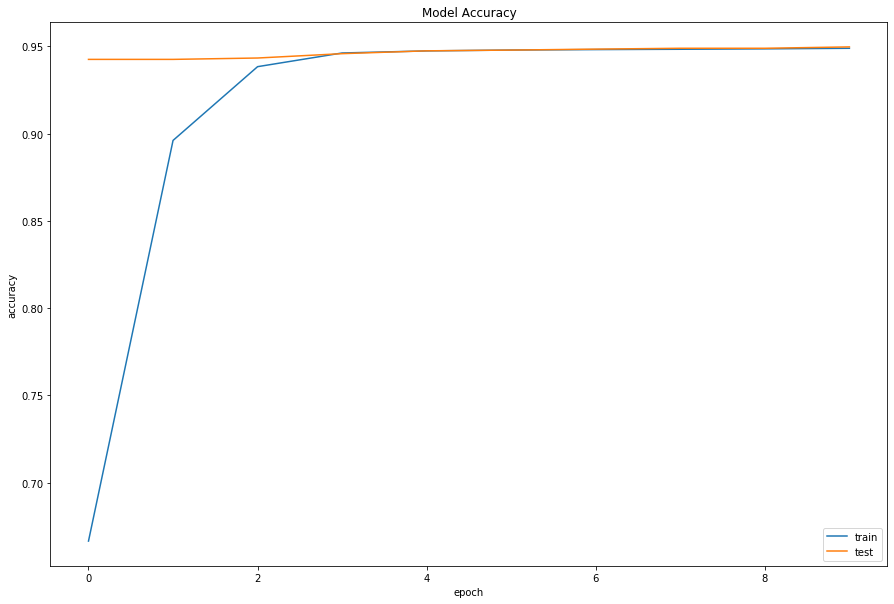

In [12]:
plt.rcParams['figure.figsize'] = [15,10]
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

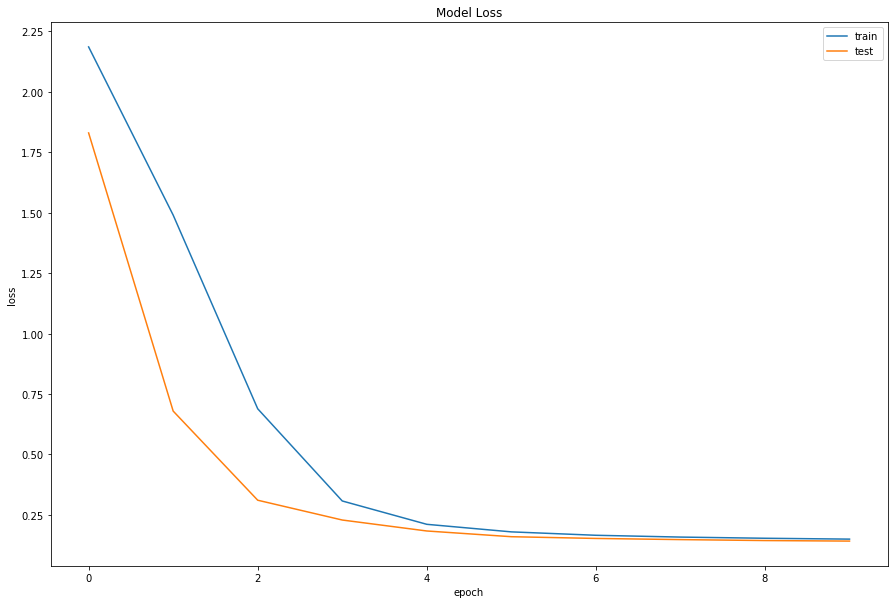

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Model Loss: {}\nModel Accuracy: {}'.format(test_loss, test_acc))

Model Loss: 0.14191451811790468
Model Accuracy: 0.949621856212616


Since the model was trained in minibatches, predictions should also be in (samples, height, width, channels) even if there is only one image.

In [46]:
pred = model.predict(np.expand_dims(x_test[21], axis=0))
pred_mask = pred.argmax(axis=3)

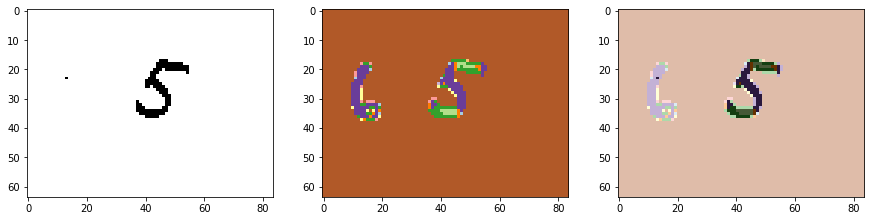

In [54]:
plt.rcParams['figure.figsize'] = [15,15]

plt.subplot(1,3,1)
plt.imshow(np.squeeze(x_test[21]).astype('uint8'), cmap='Greys')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(pred_mask), cmap='Paired', alpha=1)

plt.subplot(1,3,3)
plt.imshow(np.squeeze(x_test[21]).astype('uint8'), cmap='Greys')
plt.imshow(np.squeeze(pred_mask), cmap='Paired', alpha=0.4)

Two observations can be made based on the graphs above:
> 1. While the mask is somewhat accurate in identifying the shape of any digit present in the input, the same could not be said with the final classification of the pixels composing the identified digit.<br>
> 2. Entire digits are being predicted based on dots.

Both of these problems seem to be a limitation of the model's scene parsing capabilities, in that it cannot ensure that a digit should be composed of a single class, and that it assumed that a non-background pixel HAS to be part of a digit, even if said digit is incomplete/non-existent. However, it is also possible that these errors could stem from the operations used to visualize the predictions.

<i>KDPonce, 2020</i>